## Libraries

In [1]:
import tensorflow as tf
import pandas as pd
import rasterio
import numpy as np
import os
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Check if tensorflow is running on GPU
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Enable memory growth for GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPU")
    except RuntimeError as e:
        print("Error setting memory growth:", e)

Memory growth enabled for GPU


## Data preperation

In [3]:
# Image size
image_size = (128, 128)  # width, height

# Function to load .tif image and stack all 13 bands
def load_tif_image(file_path):
    ''' 
    function to take file path as input and provide 128x128x13 array (image) as output
        input(str) : file path
        output(array): 3 dimensioanl array as output   
    '''
    file_path = file_path.numpy().decode("utf-8")
    with rasterio.open(file_path) as src:
        bands = [src.read(band, out_shape=(image_size[1], image_size[0])) for band in range(1, 14)]
    hsi_image = np.stack(bands, axis=-1).astype(np.float32)
    return hsi_image

# Function to wrap load_tif_image with TensorFlow compatibility
def load_and_augment_image(file_path, label):
    '''
    function that takes filepath and corresponding label as input and provide tensorflow image(along with image augmentations) with label as output
        input(str,str): filepath, label
        output(tf.image, str): image, label
    '''
    hsi_image = tf.py_function(func=load_tif_image, inp=[file_path], Tout=tf.float32)
    hsi_image = tf.reshape(hsi_image, [image_size[1], image_size[0], 13])  # Ensure shape is correct

    # Apply TensorFlow augmentations
    hsi_image = tf.image.random_flip_left_right(hsi_image)
    hsi_image = tf.image.random_flip_up_down(hsi_image)
    hsi_image = tf.image.rot90(hsi_image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    return hsi_image, label


In [4]:
# Path of dataset
data_dir = r"C:\Users\jvkch\OneDrive\Desktop\ECEN\project\EuroSAT_MS\EuroSAT_MS"

# Map class names to numeric labels
class_names = sorted(os.listdir(data_dir))
class_to_label = {name: i for i, name in enumerate(class_names)}

# Generate file paths and labels
file_paths = []
labels = []
for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    label = class_to_label[class_name]
    for file_name in os.listdir(class_path):
        if file_name.endswith(".tif"):
            file_paths.append(os.path.join(class_path, file_name))
            labels.append(label)

# Create TensorFlow dataset from file paths and labels
file_paths = np.array(file_paths)
labels = np.array(labels)
dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))

# Load, augment, and batch dataset
dataset = dataset.shuffle(len(file_paths), seed=42)
train_size = int(0.7 * len(file_paths))
val_size = int(0.15 * len(file_paths))

In [5]:
# prefetching data for optimal model training
train_ds = dataset.take(train_size).map(load_and_augment_image).batch(8).prefetch(tf.data.AUTOTUNE)
val_ds = dataset.skip(train_size).take(val_size).map(load_and_augment_image).batch(8).prefetch(tf.data.AUTOTUNE)
test_ds = dataset.skip(train_size + val_size).map(load_and_augment_image).batch(8).prefetch(tf.data.AUTOTUNE)

## Data Visualization

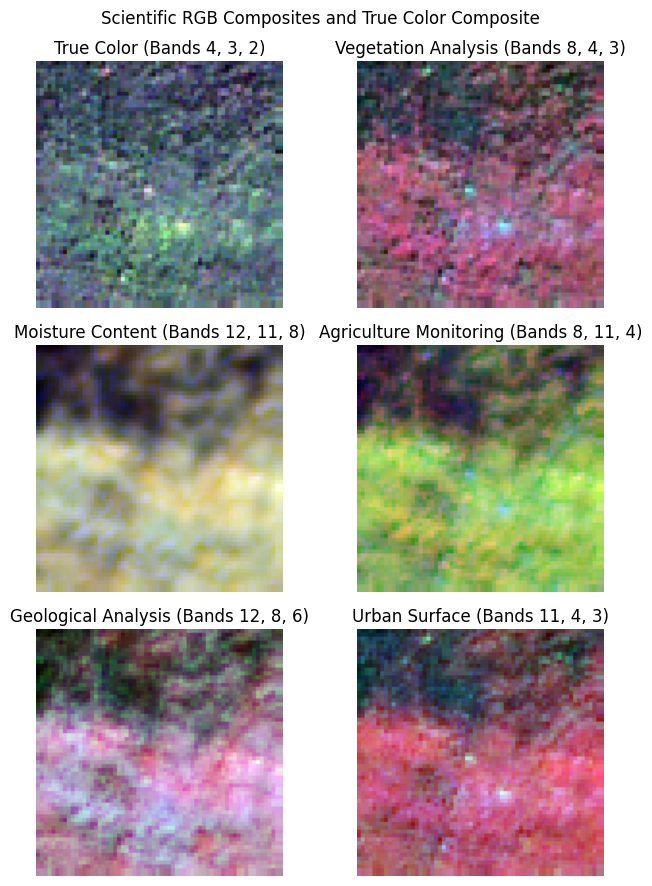

In [6]:
# function to normalize band for better visulaization
def normalize_band(band):
    '''
    function that takes one band out of 13 bands of a image and normalize it
        input(array): band
        output(array): band
    '''
    return (band - np.min(band)) / (np.max(band) - np.min(band))


# Loop through the dataset and process the first image and label
for image, label in train_ds.take(1):
    image = image[0]  # Select the first image
    label = label[0]  # Select the first label

    # True Color Composite (Bands 4, 3, 2 -> Red, Green, Blue)
    true_color = np.stack([normalize_band(image[:,:,3]), 
                           normalize_band(image[:,:,2]), 
                           normalize_band(image[:,:,1])], axis=-1)

    # Vegetation Analysis Composite (Bands 8, 4, 3 -> NIR, Red, Green)
    veg_analysis = np.stack([normalize_band(image[:,:,7]), 
                             normalize_band(image[:,:,3]), 
                             normalize_band(image[:,:,2])], axis=-1)

    # Moisture Content Composite (Bands 12, 11, 8 -> SWIR2, SWIR1, NIR)
    moisture_content = np.stack([normalize_band(image[:,:,11]), 
                                 normalize_band(image[:,:,10]), 
                                 normalize_band(image[:,:,7])], axis=-1)

    # Agriculture Monitoring Composite (Bands 8, 11, 4 -> NIR, SWIR1, Red)
    agriculture_monitoring = np.stack([normalize_band(image[:,:,7]), 
                                       normalize_band(image[:,:,10]), 
                                       normalize_band(image[:,:,3])], axis=-1)

    # Geological Analysis Composite (Bands 12, 8, 6 -> SWIR2, NIR, Red Edge 2)
    geological_analysis = np.stack([normalize_band(image[:,:,11]), 
                                    normalize_band(image[:,:,7]), 
                                    normalize_band(image[:,:,5])], axis=-1)

    # Urban Surface Composite (Bands 11, 4, 3 -> SWIR1, Red, Green)
    urban_surface = np.stack([normalize_band(image[:,:,10]), 
                              normalize_band(image[:,:,3]), 
                              normalize_band(image[:,:,2])], axis=-1)

    # Plot the composites
    fig, axs = plt.subplots(3, 2, figsize=(7, 9))
    fig.suptitle("Scientific RGB Composites and True Color Composite")

    # List of composites to plot
    composites = [
        (true_color, "True Color (Bands 4, 3, 2)"),
        (veg_analysis, "Vegetation Analysis (Bands 8, 4, 3)"),
        (moisture_content, "Moisture Content (Bands 12, 11, 8)"),
        (agriculture_monitoring, "Agriculture Monitoring (Bands 8, 11, 4)"),
        (geological_analysis, "Geological Analysis (Bands 12, 8, 6)"),
        (urban_surface, "Urban Surface (Bands 11, 4, 3)")
    ]

    # Plot each composite
    for ax, (composite, title) in zip(axs.flatten(), composites):
        ax.imshow(composite)
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


## Model selection

In [7]:
def build_conv3d_model(input_shape, num_classes):
    ''' function that takes image input shape and number of classes as input and provide tensorflow conv3d sequential model as output
        input(int,int): input shape, number of classes
        output(tf.model): tensorflow sequential model    
    '''
    model = models.Sequential([
        layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape, padding='same'),
        layers.MaxPooling3D(pool_size=(2, 2, 2)),
        layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'),
        layers.MaxPooling3D(pool_size=(2, 2, 2)),
        layers.Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'),
        layers.Dropout(0.1),
        layers.Conv3D(256, kernel_size=(3, 3, 3), activation='relu', padding='same'),
        layers.GlobalAveragePooling3D(),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [8]:
# Model input shape and number of classes
input_shape = (128, 128, 13, 1)
num_classes = 10

# Initialize the model
model = build_conv3d_model(input_shape, num_classes)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 128, 128, 13, 32)  896       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 64, 64, 6, 32)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 64, 64, 6, 64)     55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 32, 32, 3, 64)    0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 32, 32, 3, 128)    221312    
                                                                 
 dropout (Dropout)           (None, 32, 32, 3, 128)    0

## Setting model optimization

In [9]:
# setting optimizer for the model
optimizer = optimizers.Adam(learning_rate=0.001)

def linear_decay(epoch, lr):
    '''
    function that reduces learning rate at each epoch
    input(int,float): epoch, learnig rate
    output(float): new learning rate for the epoch
    '''
    decay_rate = 0.95
    return lr * decay_rate

# using learning rate scheduler with custom function
lr_callback = callbacks.LearningRateScheduler(linear_decay)

# using model check point to save the best model
checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=r'C:\Users\jvkch\OneDrive\Desktop\ECEN\project\EuroSAT_MS\tensorflow\model\best_model.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

# using early stopping to stop model training if model validation loss doesn't improve
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


In [10]:
# Compile the model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Model Training

In [11]:
# training model using system GPU
with tf.device('/GPU:0'):
  history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=30,
      callbacks=[lr_callback,early_stopping,checkpoint_callback]
  )

Epoch 1/30
2363/2363 [==============================] - ETA: 0s - loss: 1.5042 - accuracy: 0.4828
Epoch 1: val_loss improved from inf to 1.01521, saving model to C:\Users\jvkch\OneDrive\Desktop\ECEN\project\EuroSAT_MS\tensorflow\model\best_model.h5
2363/2363 [==============================] - 735s 304ms/step - loss: 1.5042 - accuracy: 0.4828 - val_loss: 1.0152 - val_accuracy: 0.6121 - lr: 9.5000e-04
Epoch 2/30
2363/2363 [==============================] - ETA: 0s - loss: 0.7742 - accuracy: 0.7265
Epoch 2: val_loss improved from 1.01521 to 0.73747, saving model to C:\Users\jvkch\OneDrive\Desktop\ECEN\project\EuroSAT_MS\tensorflow\model\best_model.h5
2363/2363 [==============================] - 670s 284ms/step - loss: 0.7742 - accuracy: 0.7265 - val_loss: 0.7375 - val_accuracy: 0.7449 - lr: 9.0250e-04
Epoch 3/30
2363/2363 [==============================] - ETA: 0s - loss: 0.5977 - accuracy: 0.7905
Epoch 3: val_loss improved from 0.73747 to 0.43442, saving model to C:\Users\jvkch\OneDrive\

In [12]:
# checking model performance on test data
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")
print(f'Loss:{test_loss}')

507/507 [==============================] - 65s 129ms/step - loss: 0.1160 - accuracy: 0.9625
Test accuracy: 96.25%
Loss:0.11598289012908936


## Visualizing the result

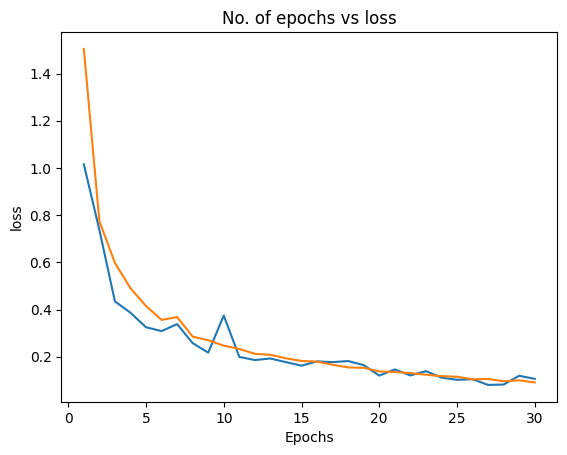

In [13]:
epochs = [i+1 for i in range(30)]

# plotting loss on each epoch
sns.lineplot(x=epochs,y=history.history['val_loss'])
sns.lineplot(x=epochs,y=history.history['loss'])
plt.title('No. of epochs vs loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()


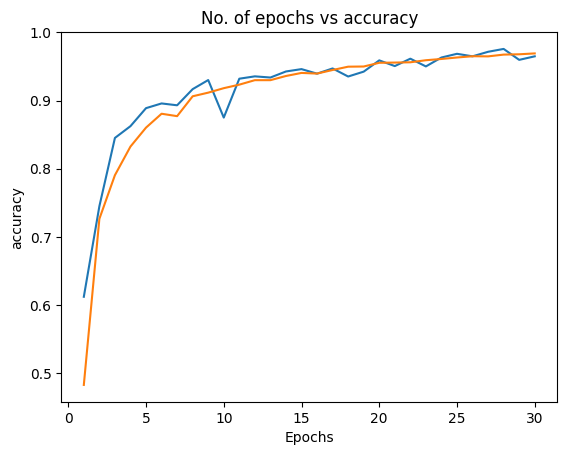

In [14]:
# plotting accuracy on each epoch

sns.lineplot(x=epochs,y=history.history['val_accuracy'])
sns.lineplot(x=epochs,y=history.history['accuracy'])
plt.title('No. of epochs vs accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.show()

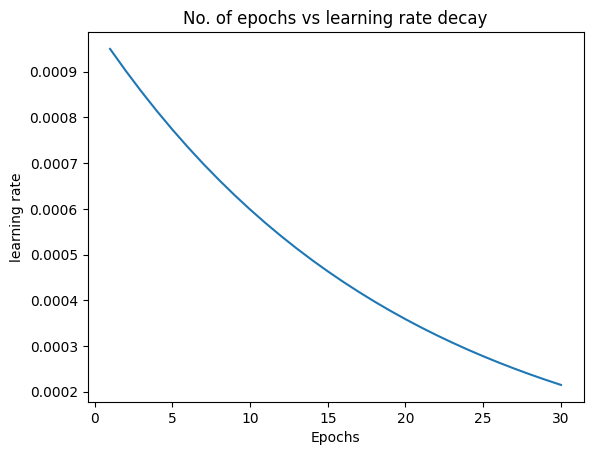

In [15]:
# plotting learning rate on each epoch
sns.lineplot(x=epochs,y=history.history['lr'])
plt.title('No. of epochs vs learning rate decay')
plt.xlabel('Epochs')
plt.ylabel('learning rate')
plt.show()

## Misc

1/1 [==============================] - 0s 27ms/step


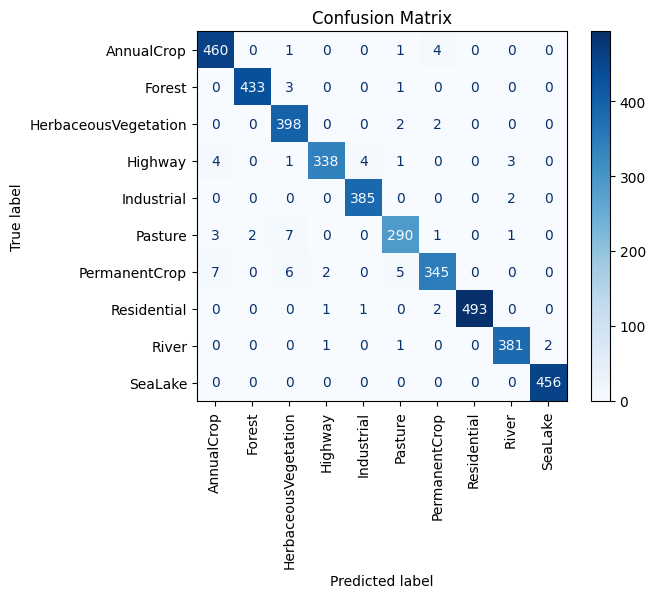

In [19]:
# Load the saved model
model = tf.keras.models.load_model(r'C:\Users\jvkch\OneDrive\Desktop\ECEN\project\EuroSAT_MS\tensorflow\model\best_model.h5')

class_names = sorted(os.listdir(data_dir))

true_labels = []
predicted_labels = []

for images, labels in test_ds:
    # Predict class probabilities
    predictions = model.predict(images)
    # Get predicted class labels
    predicted_classes = np.argmax(predictions, axis=1)
    true_labels.extend(labels.numpy().tolist())
    predicted_labels.extend(predicted_classes.tolist())

# Convert lists to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Step 5: Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xticks(rotation=90)
plt.show()

In [20]:
precision = []
recall = []
f1_score = []

for i in range(len(class_names)):
    # True Positives
    tp = conf_matrix[i, i]
    # False Positives: Sum of column i excluding tp
    fp = conf_matrix[:, i].sum() - tp
    # False Negatives: Sum of row i excluding tp
    fn = conf_matrix[i, :].sum() - tp

    # Precision: tp / (tp + fp)
    if tp + fp > 0:
        precision.append(tp / (tp + fp))
    else:
        precision.append(0.0)

    # Recall: tp / (tp + fn)
    if tp + fn > 0:
        recall.append(tp / (tp + fn))
    else:
        recall.append(0.0)

    # F1-Score: 2 * (precision * recall) / (precision + recall)
    if precision[-1] + recall[-1] > 0:
        f1_score.append(2 * (precision[-1] * recall[-1]) / (precision[-1] + recall[-1]))
    else:
        f1_score.append(0.0)

# Step 8: Overall Metrics
overall_precision = np.mean(precision)
overall_recall = np.mean(recall)
overall_f1_score = np.mean(f1_score)

# Step 7: Create a DataFrame for the metrics
metrics_data = {
    "Class": class_names,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1_score
}

# Create a DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Calculate and add overall metrics
overall_metrics = pd.DataFrame({
    "Class": ["Overall"],
    "Precision": [overall_precision],
    "Recall": [overall_recall],
    "F1-Score": [overall_f1_score]
})

# Append overall metrics to the table
final_metrics_df = pd.concat([metrics_df, overall_metrics], ignore_index=True)

final_metrics_df


,Class,Precision,Recall,F1-Score
0,AnnualCrop,0.970464,0.987124,0.978723
1,Forest,0.995402,0.990847,0.993119
2,HerbaceousVegetation,0.956731,0.990050,0.973105
3,Highway,0.988304,0.962963,0.975469
4,Industrial,0.987179,0.994832,0.990991
5,Pasture,0.963455,0.953947,0.958678
6,PermanentCrop,0.974576,0.945205,0.959666
7,Residential,1.000000,0.991952,0.995960
8,River,0.984496,0.989610,0.987047
9,SeaLake,0.995633,1.000000,0.997812


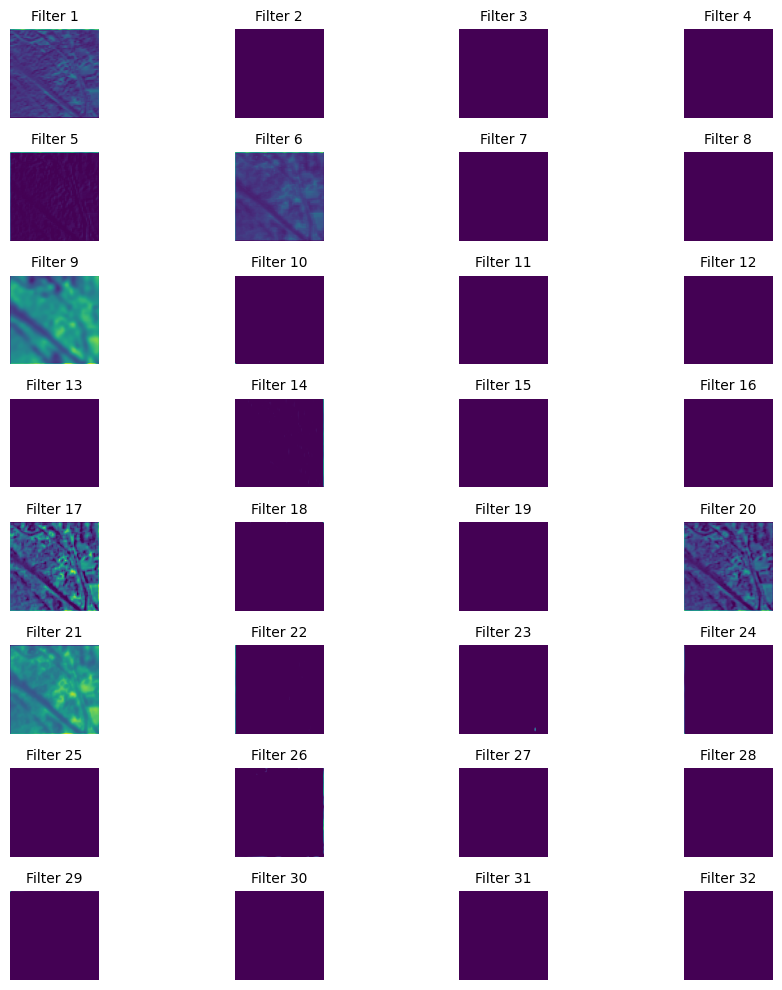

In [21]:
example_image, example_label = next(iter(test_ds))
example_image = example_image[0]  # pick a sample
example_label = example_label[0]  # Corresponding label

# pick first layer of model for representation
last_conv_layer = model.get_layer("conv3d")

# Create a model that outputs the feature maps and the final prediction
grad_model = tf.keras.models.Model(inputs=model.input, outputs=[last_conv_layer.output, model.output])

# Predict output of sample image
output = grad_model(np.expand_dims(example_image, axis=0))

feature_maps = output[0]  # Shape: (batch_size,height, width, depth, num_filters)

# average the feature maps across the depth dimension (axis=3)
avg_feature_maps = np.mean(feature_maps, axis=3)  # Shape: (batch_size, height, width, num_filters)

# Remove batch dimension
avg_feature_maps = avg_feature_maps[0]  # Now the shape is (height, width, num_filters)

# Step 2: Visualize the averaged feature maps for each filter
num_filters = avg_feature_maps.shape[-1]  # Number of filters in the Conv3D layer

# Plot the feature maps for each filter
fig, axes = plt.subplots(8, 4, figsize=(10, 10))
for i in range(num_filters):
    row = i // 4 
    col = i % 4
    ax = axes[row, col]
    ax.imshow(avg_feature_maps[:, :, i], cmap='viridis')
    ax.set_title(f"Filter {i+1}", fontsize=10)
    ax.axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()
